In [8]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from ncmcm.bundlenet.bundlenet import BunDLeNet, train_model
from ncmcm.bundlenet.utils import prep_data, timeseries_train_test_split
from ncmcm.visualisers.latent_space import LatentSpaceVisualiser
from ray import tune, train
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.bayesopt import BayesOptSearch

In [9]:
algorithm = 'BunDLeNet'
rat_name = 'achilles' # ['achilles', 'gatsby','cicero', 'buddy']
data = np.load(f'../../data/raw/rat_hippocampus/{rat_name}.npz')
x, b = data['x'], data['b']
x = x - np.min(x)


In [10]:
def train_bundlenet(config):    
    # Extract hyperparameters from the config dictionary
    learning_rate = config["learning_rate"]
    latent_dim = int(config["latent_dim"])
    n_epochs = int(config["n_epochs"])
    win = int(config["win"])
    
    x_, b_ = prep_data(x, b, win=win)

    x_train, x_test, b_train_1, b_test_1 = timeseries_train_test_split(x_, b_)

    model = BunDLeNet(latent_dim=latent_dim, num_behaviour=b_train_1.shape[1])

    train_history, test_history = train_model(
        x_train,
        b_train_1,
        model,
        b_type='continuous',
        gamma=0.9,
        learning_rate=learning_rate,
        n_epochs=n_epochs,
        initialisation= (5, 20),
        validation_data=(x_test, b_test_1),
    )

    # Report validation loss (or another metric) back to Ray Tune
    train.report({"val_loss": test_history[-1, -1]})

In [11]:
search_space = {
    "win": tune.loguniform(1, 50),
    "learning_rate": tune.loguniform(1e-5, 1e-1),
    "latent_dim": tune.uniform(1,10),
    "n_epochs": tune.uniform(10, 500)
}

scheduler = ASHAScheduler(metric="val_loss", mode="min", max_t=500, grace_period=20, reduction_factor=2)
search_algo = BayesOptSearch(metric="val_loss", mode="min")


tuner = tune.Tuner(
    tune.with_parameters(train_bundlenet),
    tune_config=tune.TuneConfig(
        search_alg=search_algo,
        num_samples=100,
        scheduler=scheduler,
    ),
    param_space=search_space,
)
results = tuner.fit()

2024-09-11 17:25:42,937	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/akshey/ray_results/train_bundlenet_2024-09-11_15-18-49' in 0.0563s.
2024-09-11 17:25:42,965	INFO tune.py:1041 -- Total run time: 7613.95 seconds (7613.82 seconds for the tuning loop).


In [12]:
best_result = results.get_best_result(metric='val_loss', mode='min')
print("Minimum validation loss:", best_result.metrics['val_loss'])
print("Best hyperparameters found were: ", best_result.config)


Minimum validation loss: 0.0051643668091855945
Best hyperparameters found were:  {'win': 36.0584775157588, 'learning_rate': 0.003392201262383193, 'latent_dim': 2.141638156189396, 'n_epochs': 18.699114329207905}


In [13]:
learning_rate = best_result.config["learning_rate"]
latent_dim = int(best_result.config["latent_dim"])
n_epochs = int(best_result.config["n_epochs"])
win = int(best_result.config["win"])


In [14]:
x_, b_ = prep_data(x, b, win=win)

x_train, x_test, b_train_1, b_test_1 = timeseries_train_test_split(x_, b_)


# Deploy BunDLe Net
model = BunDLeNet(latent_dim=latent_dim, num_behaviour=b_.shape[1])

train_history, test_history = train_model(
    x_train,
    b_train_1,
    model,
    b_type='continuous',
    gamma=0.9,
    learning_rate=learning_rate,
    n_epochs=n_epochs,
    initialisation=(5,20),
    validation_data=(x_test, b_test_1),
)
print(f'val loss: {test_history[-1,-1]}')

2024-09-11 17:30:37.735726: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-09-11 17:30:37.735750: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: akshey-System-Product-Name
2024-09-11 17:30:37.735755: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: akshey-System-Product-Name
2024-09-11 17:30:37.735819: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.107.2
2024-09-11 17:30:37.735835: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.90.7
2024-09-11 17:30:37.735839: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 550.90.7 does not match DSO version 550.107.2 -- cannot find working devices in this 

model: 0 val loss: 0.005612773199876149
model: 1 val loss: 0.0075441020734918615
model: 2 val loss: 0.006599135658082862
model: 3 val loss: 0.005871577591945728
model: 4 val loss: 0.01150262663140893


Loss [Markov, Behaviour, Total]: [0.005  0.0013 0.0063]: 100%|█| 18/18 [00:08<

val loss: 0.006196627533063293


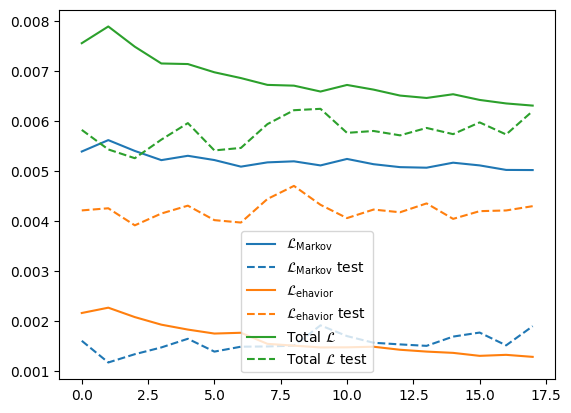

In [15]:
plt.figure()
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, label in enumerate([
    r"$\mathcal{L}_{\mathrm{Markov}}$",
    r"$\mathcal{L}_{\mathrm{ehavior}}$",
    r"Total $\mathcal{L}$"
]):
    plt.plot(train_history[:, i], label=label, c=colors[i])
    plt.plot(test_history[:, i], label=label + ' test', c=colors[i], linestyle='--')
plt.legend()

In [16]:
# Projecting into latent space
y0_tr = model.tau(x_train[:, 0]).numpy()
y1_tr = model.tau(x_train[:, 1]).numpy()

y0_tst = model.tau(x_test[:, 0]).numpy()
y1_tst = model.tau(x_test[:, 1]).numpy()

y0_ = model.tau(x_[:, 0]).numpy()
y1_ = model.tau(x_[:, 1]).numpy()

<IPython.core.display.Javascript object>


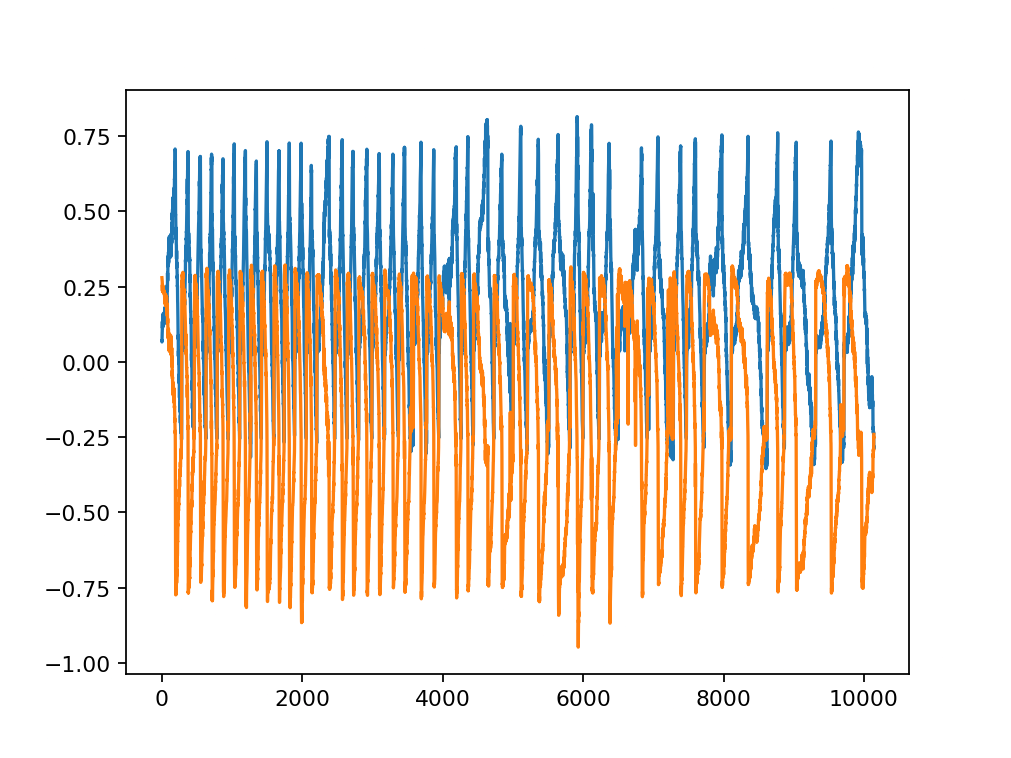

In [17]:
%matplotlib notebook
plt.figure()
plt.plot(y0_)

In [18]:
y0_tr = np.c_[y0_tr, np.zeros_like(y0_tr[:,0])]
y1_tr = np.c_[y1_tr, np.zeros_like(y1_tr[:,0])]
y0_tst = np.c_[y0_tst, np.zeros_like(y0_tst[:,0])]
y1_tst = np.c_[y1_tst, np.zeros_like(y1_tst[:,0])]
y0_tr

array([[ 0.06992733,  0.27986795,  0.        ],
       [ 0.06630667,  0.276876  ,  0.        ],
       [ 0.0838986 ,  0.2715472 ,  0.        ],
       ...,
       [-0.27185583, -0.24881792,  0.        ],
       [-0.28920066, -0.25307447,  0.        ],
       [-0.28250885, -0.2408632 ,  0.        ]], dtype=float32)

<IPython.core.display.Javascript object>


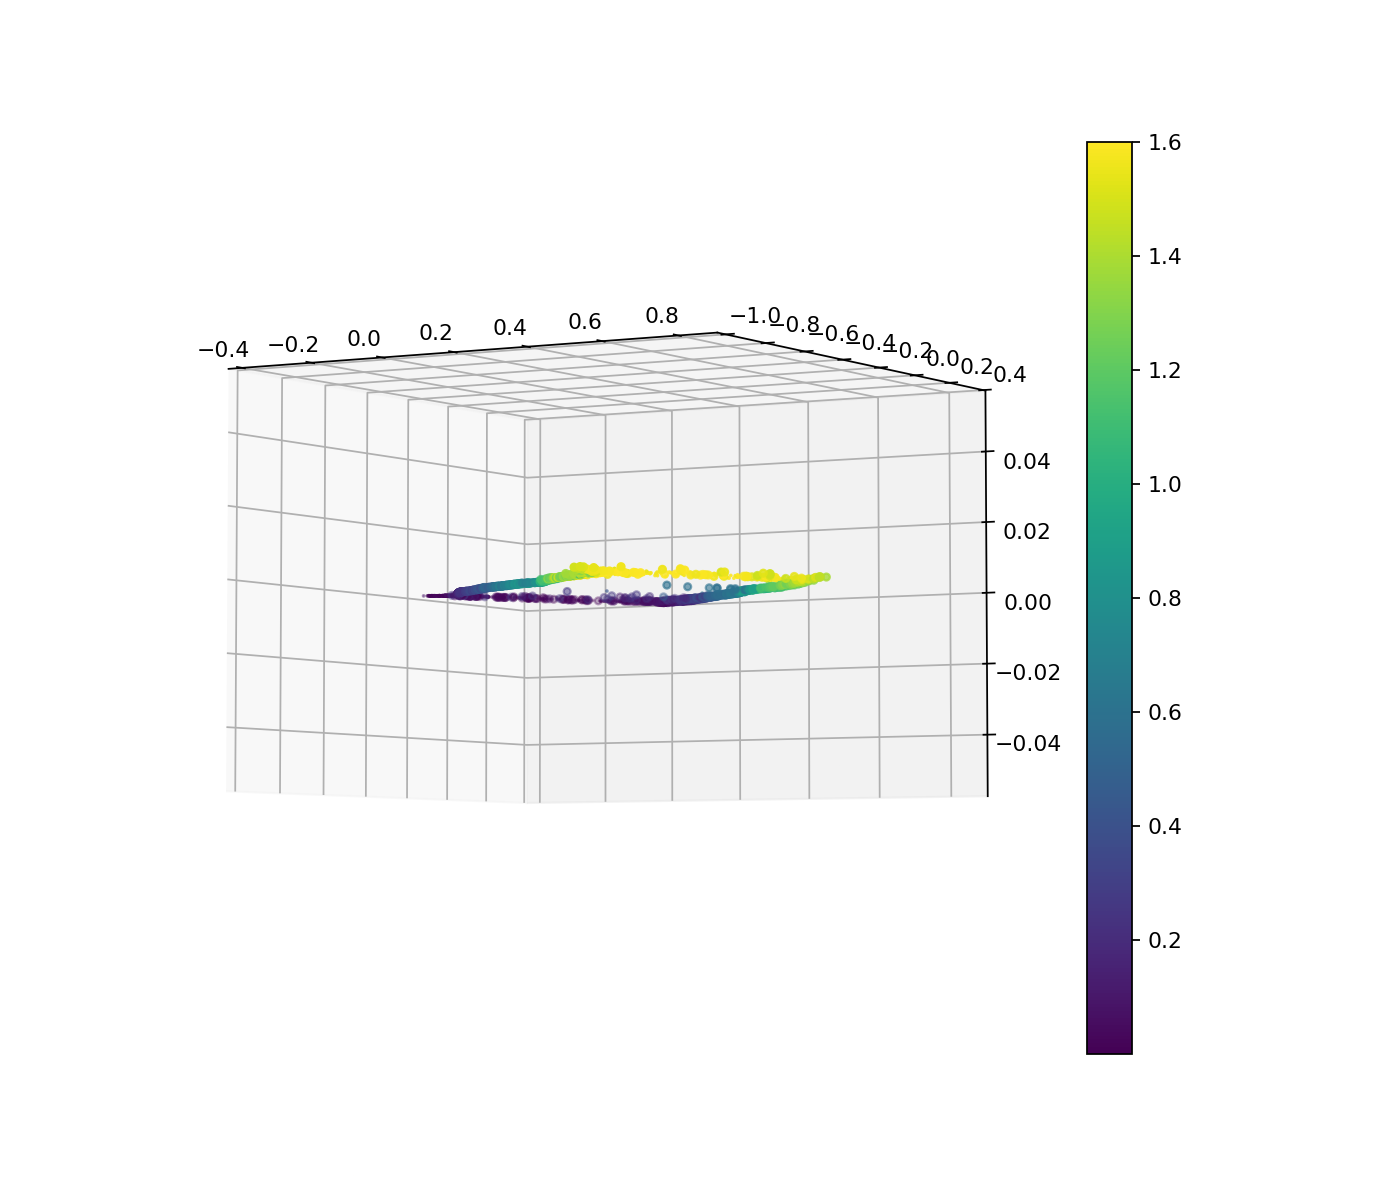

In [23]:
%matplotlib notebook
# Continuous variable plotting
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')
# ax.axis('off')
tr_pts = ax.scatter(y0_tr[:, 0], y0_tr[:, 1], y0_tr[:, 2], c=b_train_1[:, 0], s=0.5)
tst_pts = ax.scatter(y0_tst[:, 0], y0_tst[:, 1], y0_tst[:, 2], c=b_test_1[:, 0], s=10)
plt.colorbar(tr_pts)
plt.show()

<IPython.core.display.Javascript object>


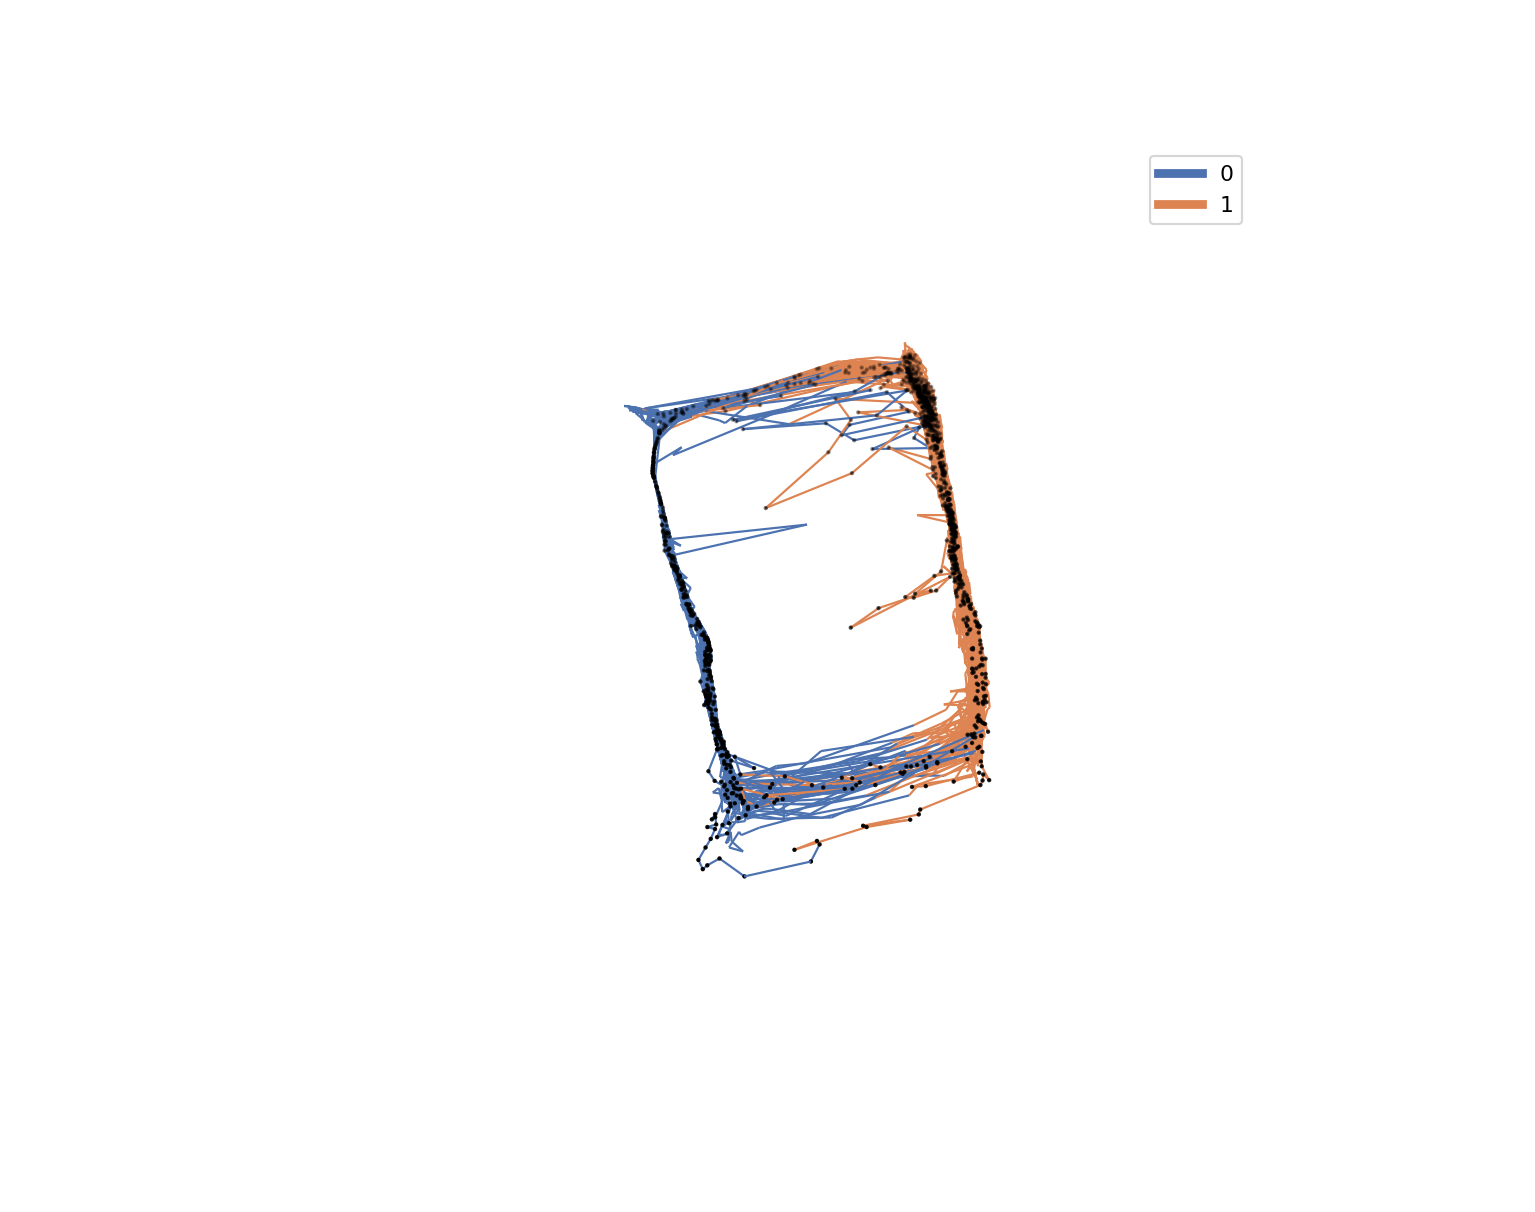

In [25]:
# Discrete variable plotting
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')

vis = LatentSpaceVisualiser(
    y=y0_tr,
    b=b_train_1[:, 1].astype(int),
    b_names=['0', '1']
)
fig, ax = vis._plot_ps(fig, ax, arrow_length_ratio=0.0001)

vis = LatentSpaceVisualiser(
    y=y0_tst,
    b=b_test_1[:, 1].astype(int),
    b_names=['0', '1'],
    show_points=True
)
fig, ax = vis._plot_ps(fig, ax, arrow_length_ratio=0.01)

plt.show()

In [21]:
save_data=False
if save_data:
    # Save the weights
    # model.save_weights(f'data/generated/BunDLeNet_model_rat_{rat_name}')
    print(f'data/generated/saved_Y/y0_tr__{algorithm}_rat_{rat_name}')
    np.savetxt(f'data/generated/saved_Y/y0_tr__{algorithm}_rat_{rat_name}', y0_tr)
    np.savetxt(f'data/generated/saved_Y/y1_tr__{algorithm}_rat_{rat_name}', y1_tr)
    np.savetxt(f'data/generated/saved_Y/y0_tst__{algorithm}_rat_{rat_name}', y0_tst)
    np.savetxt(f'data/generated/saved_Y/y1_tst__{algorithm}_rat_{rat_name}', y1_tst)
    np.savetxt(f'data/generated/saved_Y/b_train_1__{algorithm}_rat_{rat_name}', b_train_1)
    np.savetxt(f'data/generated/saved_Y/b_test_1__{algorithm}_rat_{rat_name}', b_test_1)
